In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib as mpl
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import seaborn as sns
# import pickle

plt.style.use('ggplot')
mpl.rcParams['figure.dpi'] = 100

#### Question 1

In [2]:
# Q1 - SPY Index
spy = pd.read_excel(r'S&P_500_stock_index.xlsx')
spy.rename(columns={'Dates':'Date'}, inplace=True)
spy['SP500 index'] = spy['SP500 index'].pct_change()
spy.dropna(inplace=True)
spy.reset_index(drop=True, inplace=True)

In [3]:
# Q1 - US Aggregate Bond Index
bond = pd.read_excel(r'US_Aggregate_Bond_Index.xlsx')
bond.rename(columns={'LBUSTRUU Index ':'Agg Bond Index', 'Dates': 'Date'}, inplace=True)
bond['Agg Bond Index'] = bond['Agg Bond Index'].pct_change()
bond.dropna(inplace=True)
bond.reset_index(drop=True, inplace=True)

In [4]:
# Q1 - Risk Free Rate
rf = pd.read_excel(r'Risk-free_rate_of_return.xlsx')
rf.rename(columns={'Risk free rate of return ': 'i_rf'}, inplace=True)

In [5]:
# Q1 - Set up Merged DataFrame
df_ind = pd.merge(spy, bond, on='Date', how='inner')
df_final = pd.merge(df_ind, rf, on='Date', how='inner')

# Q1 - Calculate Excess Returns (SPY)
df_final['Excess Returns (SPY)'] = df_final['SP500 index'] - df_final['i_rf']

# Q1 - Calculate Excess Returns (Bond)
df_final['Excess Returns (Bond)'] = df_final['Agg Bond Index'] - df_final['i_rf']
df_final.drop(columns=['SP500 index', 'Agg Bond Index', 'i_rf'], inplace=True)

In [6]:
# Q1 - Function
def sum_stats(df):
    
    # Annualised Mean from Monthly Excess Returns
    mean_spy = (1 + df['Excess Returns (SPY)'].mean())**12 - 1
    mean_bond = (1 + df['Excess Returns (Bond)'].mean())**12 - 1 
    # Annualised Standard Deviation from Monthly Excess Returns
    standard_deviation_spy = df['Excess Returns (SPY)'].std() * np.sqrt(12)
    standard_deviation_bond = df['Excess Returns (Bond)'].std() * np.sqrt(12)

    # Annualised Sharpe Ratio
    sharpe_ratio_spy = mean_spy / standard_deviation_spy
    sharpe_ratio_bond = mean_bond / standard_deviation_bond

    # Skewness from Monthly Returns
    skewness_spy = df['Excess Returns (SPY)'].skew()
    skewness_bond = df['Excess Returns (Bond)'].skew()

    # Kurtosis from Monthly Returns
    kurtosis_spy = df['Excess Returns (SPY)'].kurtosis()
    kurtosis_bond = df['Excess Returns (Bond)'].kurtosis()

    summary_spy = pd.Series([mean_spy, standard_deviation_spy, sharpe_ratio_spy, skewness_spy, kurtosis_spy], name='SPY')
    summary_bond = pd.Series([mean_bond, standard_deviation_bond, sharpe_ratio_bond, skewness_bond, kurtosis_bond], name='Bond')
    df_summary = pd.concat([summary_spy, summary_bond], axis=1)
    df_summary.index = ['Annualized Mean', 'Standard Deviation', 'Sharpe Ratio', 'Skewness', 'Kurtosis']

    return df_summary

sum_stats(df_final)

,SPY,Bond
Annualized Mean,0.064104,0.032650
Standard Deviation,0.150755,0.051107
Sharpe Ratio,0.425221,0.638863
Skewness,-0.634822,0.422147
Kurtosis,2.117413,6.242155


#### Question 2

In [7]:
# Q2 - Divide Sample into 2 Sub-Samples
# Convert to Datetime
df_final['Date'] = pd.to_datetime(df_final['Date'])

# In-sample
startDate_insample = dt.datetime(1980, 1, 31)
endDate_insample = dt.datetime(1999, 12, 31)

# Out-of-sample
startDate_outsample = dt.datetime(2000, 1, 31)
endDate_outsample = dt.datetime(2021, 12, 31)


In [8]:
# Define function to split data into in sample & out of sample periods
def sample_split(df, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample):
    
    df_insample = df[(df['Date'] >= startDate_insample) & 
                     (df['Date'] <= endDate_insample)].reset_index(drop=True)
    df_outsample = df[(df['Date'] >= startDate_outsample) & 
                      (df['Date'] <= endDate_outsample)].reset_index(drop=True)

    return df_insample, df_outsample

In [9]:
# Function
def recurs_mean_forecast(df, startDate_insample, endDate_insample, 
                         startDate_outsample, endDate_outsample):
    # Divide into in-sample & out of sample periods
    df_insample, df_outsample = sample_split(df, startDate_insample, endDate_insample,
                                              startDate_outsample, endDate_outsample)

    # Create DataFrame
    forecast_df = pd.DataFrame(columns=df.columns)
    for i in range(len(df_insample), len(df)):
        forecast_df.loc[i-len(df_insample)] = df.iloc[:i].mean(numeric_only=True)
    forecast_df['Date'] = df_outsample['Date'].reset_index(drop=True)
    
    return forecast_df

df_mean_forecast = recurs_mean_forecast(df_final, startDate_insample, 
                                        endDate_insample, startDate_outsample, endDate_outsample)

#### Question 3

In [10]:
# Set up DataFrame
df_var = pd.read_excel(r'PredictorData2022.xlsx')
df_var['yyyymm'] = pd.to_datetime(df_var['yyyymm'], format='%Y%m')
df_var.rename(columns={'yyyymm': 'Date'}, inplace=True)

df_var = df_var[(df_var['Date'] > startDate_insample - pd.DateOffset(months=2)) & 
                (df_var['Date'] <= endDate_outsample)]

df_var.drop(columns=['Index', 'Date'], inplace=True)
df_var = df_var.dropna(axis=1).reset_index(drop=True)

df_var.insert(0, 'Date', df_final['Date'].reset_index(drop=True))

df_var = df_var.merge(df_final, on='Date', how='inner')

c:\Users\Gavin\anaconda3\lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


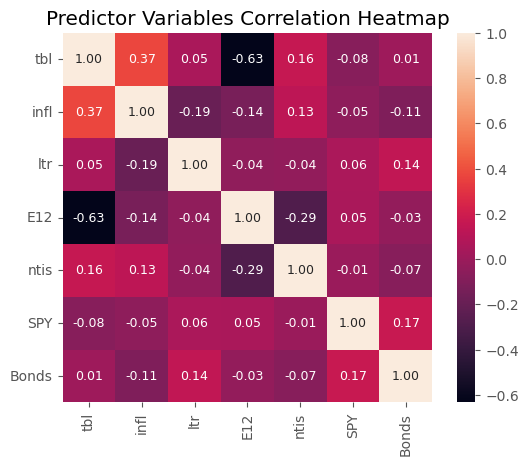

In [11]:
# Q3 - Test Correlation of Predictor Variables
pred_vars = ['tbl', 'infl', 'ltr',  'E12', 'ntis', 'Excess Returns (SPY)', 'Excess Returns (Bond)']
corr_matrix = df_var[pred_vars].rename(columns={
    'Excess Returns (SPY)': 'SPY', 'Excess Returns (Bond)': 'Bonds'}).corr()
cols = corr_matrix.columns
hm = sns.heatmap(corr_matrix, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 9}, yticklabels=cols, xticklabels=cols, cmap='rocket')
hm.set_title("Predictor Variables Correlation Heatmap")
plt.xticks(rotation='90')
plt.yticks(rotation='0')
plt.show()

pred_vars = ['tbl', 'infl', 'ltr',  'E12', 'ntis']

In [12]:
def RecursiveLS_Ordinary(df_x, df_y, startDate_insample, endDate_insample, 
                         startDate_outsample, endDate_outsample):

    # call sample_split() to split dfs into in & out of sample periods
    df_x_insample, df_x_outsample = sample_split(df_x, startDate_insample, endDate_insample, 
                                                 startDate_outsample, endDate_outsample)
    df_y_insample, df_y_outsample = sample_split(df_y, startDate_insample, endDate_insample, 
                                                 startDate_outsample, endDate_outsample)

    df_y_insample.drop(columns='Date', inplace=True)
    out_date = df_y_outsample.pop('Date')
   
    df_forecast_ols = pd.DataFrame()
    
    for variable in df_x_insample.drop(columns=['Date']).columns:
        
        forecast = pd.DataFrame()
        col_name = 'forecast: ' + variable
        
        # set up data for OLS 
        df_x_insample_var = sm.add_constant(df_x_insample[variable])
        df_x_outsample_var = sm.add_constant(df_x_outsample[variable])
        df_y_insample_copy = df_y_insample.copy()
        
        for i, exog_i in enumerate(df_y_outsample.values):
            
            # extract endogenous variables of ith observation
            endog_i = df_x_outsample_var.loc[df_x_outsample_var.index==i]

            # Fit our OLS model on in-sample period
            model = sm.OLS(df_y_insample_copy, df_x_insample_var)
            res = model.fit()

            # append prediction to forecast
            forecast = pd.concat([forecast, res.predict(endog_i)], axis=0, ignore_index=True)

            # Include previous observation in next insample
            df_x_insample_var = pd.concat([df_x_insample_var, endog_i], axis=0, ignore_index=True)
            df_y_insample_copy = pd.concat([df_y_insample_copy, pd.DataFrame(
                exog_i, columns=df_y_insample_copy.columns)], axis=0, ignore_index=True)

        df_forecast_ols[col_name] = forecast

    df_forecast_ols.insert(0, 'Date', out_date)

    return df_forecast_ols

In [13]:
df_var_sp = df_var[pred_vars]
df_var_sp.insert(0, 'Date', df_var['Date'])

df_y = df_var[['Date', 'Excess Returns (SPY)']]

sp_forecast_ols = RecursiveLS_Ordinary(df_var_sp, df_y, startDate_insample, endDate_insample,
                                        startDate_outsample, endDate_outsample)
sp_forecast_ols['forecast: ensemble'] = sp_forecast_ols.mean(axis=1, numeric_only=True)

In [14]:
df_var_bond = df_var[pred_vars]
df_var_bond.insert(0, 'Date', df_var['Date'])

df_y = df_var[['Date', 'Excess Returns (Bond)']]

bond_forecast_ols = RecursiveLS_Ordinary(df_var_bond, df_y, startDate_insample, endDate_insample,
                                          startDate_outsample, endDate_outsample)
bond_forecast_ols['forecast: ensemble'] = bond_forecast_ols.mean(axis=1, numeric_only=True)

In [15]:
# Define function to standardize a dataset
def Standardizer(df):
    scaler = StandardScaler()
    scaler.fit(df)
    df_standard = pd.DataFrame(scaler.transform(df), columns=df.columns)
    
    return df_standard, scaler

In [16]:
def RecursiveLS_Penalized(df_x, df_y, startDate_insample, endDate_insample, 
                          startDate_outsample, endDate_outsample):

    # call sample_split() to split dfs into in & out of sample periods
    df_x_insample, df_x_outsample = sample_split(df_x, startDate_insample, endDate_insample,
                                                startDate_outsample, endDate_outsample)
    
    df_y_insample, df_y_outsample = sample_split(df_y, startDate_insample, endDate_insample, 
                                                 startDate_outsample, endDate_outsample)

    df_x_insample.drop(columns='Date', inplace=True)
    df_y_insample.drop(columns='Date', inplace=True)
    df_x_outsample.drop(columns='Date', inplace=True)
    out_date = df_y_outsample.pop('Date')
   
    df_forecast_pen = pd.DataFrame()
    
    for L1_wt in [0,1]: # 0 corresponds to ridge regression, 1 to lasso
            
        forecast = pd.DataFrame()
        if L1_wt == 0:
            col_name = 'forecast: ridge'
            alpha = 2.75
        else:
            col_name = 'forecast: lasso'
            alpha = 0.13
        
        for i, exog_i in enumerate(df_y_outsample.values):
            
            # Standardize exogenous variables
            exog_i = pd.DataFrame(exog_i, columns=df_y_insample.columns)
            df_y_insample_standard, scaler_y = Standardizer(df_y.iloc[:len(df_y_insample)+i,1:])
            exog_i = scaler_y.transform(exog_i)

            # extract variables of ith observation
            endog_i = df_x_outsample.iloc[i,:]
            
            # Standardize endogenous variables
            df_x_insample_standard, scaler_x = Standardizer(df_x.iloc[:len(df_y_insample)+i,1:])
            endog_i = scaler_x.transform(pd.DataFrame(endog_i.values.reshape(1, -1), 
                                                      columns=df_x_insample.columns))
            
            # Fit our OLS model on in-sample period
            model = sm.OLS(df_y_insample_standard, df_x_insample_standard)
            res = model.fit_regularized(method='elastic_net', L1_wt=L1_wt, alpha=alpha)

            # Transform forecast back to raw returns & append to forecast df
            raw_forecast = scaler_y.mean_ + scaler_y.scale_ * pd.Series(res.predict(endog_i))
            forecast = pd.concat([forecast, raw_forecast], axis=0, ignore_index=True)

        df_forecast_pen[col_name] = forecast
    df_forecast_pen.insert(0, 'Date', out_date)

    return df_forecast_pen

In [17]:
df_y = df_var[['Date', 'Excess Returns (SPY)']]

sp_forecast_pen = RecursiveLS_Penalized(df_var_sp, df_y, startDate_insample, endDate_insample,
                                         startDate_outsample, endDate_outsample)

In [18]:
df_y = df_var[['Date', 'Excess Returns (Bond)']]

bond_forecast_pen = RecursiveLS_Penalized(df_var_bond, df_y, startDate_insample, endDate_insample,
                                           startDate_outsample, endDate_outsample)

In [19]:
# Q3 - DM-Test
# Define function to calculate DM-Test
def DM_test(df, actual, forecast1, forecast2):
    
    df_test=df.copy()
    # Calculate squared errors
    df_test['error1'] = (df_test[actual] - df_test[forecast1]) ** 2
    df_test['error2'] = (df_test[actual] - df_test[forecast2]) ** 2

    # Calculate MSFE ratio
    msfe_ratio = df_test['error1'].mean() / df_test['error2'].mean()

    # Autocorrelation Function
    h = len(df_test)**(1/3)
    h_lags = int(h)

    acf = sm.tsa.stattools.acf(df_test['error1'] - df_test['error2'], nlags=h_lags, fft=False)
    
    gamma = (acf[1:].sum() * 2) + 1

    # Calculate test statistic
    d_bar = (df_test['error1'] - df_test['error2']).mean()
    test_stat = np.divide(d_bar, np.sqrt(gamma / len(df_test)))

    # Calculate p-value
    p_value = 1 - norm.cdf(test_stat)

    return test_stat, p_value, msfe_ratio

In [20]:
# Q3 - Prepare DataFrame for DM-Test (SPY)
df_y = df_var[['Date', 'Excess Returns (SPY)']].copy()
sp_forecast = df_y.merge(df_mean_forecast[['Date', 'Excess Returns (SPY)']], how='inner', 
                         on='Date').merge(sp_forecast_ols, how='inner', on='Date').merge(sp_forecast_pen, how='inner', on='Date')

sp_forecast.rename(columns={'Excess Returns (SPY)_x': 'SPY', 
        'Excess Returns (SPY)_y': 'forecast: mean'}, inplace=True)

# Prepare DataFrames for DM-Test Storage
dm_test_stats_spy = pd.DataFrame(columns=['Model (SPY)',  'MSFE Ratio', 'Test Statistic', 'p-value'])

# Run DM-Test for each model
for column in sp_forecast.columns[3:]:

    test_stat, p_value, msfe_ratio = DM_test(sp_forecast, 'SPY', 'forecast: mean', column)
    dm_test_stats_spy = pd.concat([dm_test_stats_spy, pd.Series([column, 
                                                                 msfe_ratio, test_stat, p_value], index=dm_test_stats_spy.columns).to_frame().T], ignore_index=True)

In [21]:
dm_test_stats_spy

,Model (SPY),MSFE Ratio,Test Statistic,p-value
0,forecast: tbl,0.989875,-0.000234,0.500093
1,forecast: infl,0.973728,-0.000669,0.500267
2,forecast: ltr,0.998295,-0.000113,0.500045
3,forecast: E12,0.983483,-0.000441,0.500176
4,forecast: ntis,0.987259,-0.000332,0.500132
5,forecast: ensemble,0.990674,-0.000254,0.500101
6,forecast: ridge,0.988206,-0.000316,0.500126
7,forecast: lasso,0.998351,-0.000067,0.500027


In [22]:
# Q3 - Prepare DataFrame for DM-Test (Bond)
df_y = df_var[['Date', 'Excess Returns (Bond)']].copy()
bond_forecast = df_y.merge(df_mean_forecast[['Date', 'Excess Returns (Bond)']], how='inner',
                            on='Date').merge(bond_forecast_ols, how='inner', 
                                             on='Date').merge(bond_forecast_pen, how='inner', on='Date')

bond_forecast.rename(columns={'Excess Returns (Bond)_x': 'Bond', 
                              'Excess Returns (Bond)_y': 'forecast: mean'}, inplace=True)

# Prepare DataFrames for DM-Test Storage
dm_test_stats_bond = pd.DataFrame(columns=['Model (Bond)',  'MSFE Ratio', 'Test Statistic', 'p-value'])

# Run DM-Test for each model
for column in bond_forecast.columns[3:]:

    test_stat, p_value, msfe_ratio = DM_test(bond_forecast, 'Bond', 'forecast: mean', column)
    dm_test_stats_bond = pd.concat([dm_test_stats_bond, pd.Series([column, 
                                                                   msfe_ratio, test_stat, p_value], index=dm_test_stats_bond.columns).to_frame().T], ignore_index=True)

In [23]:
dm_test_stats_bond

,Model (Bond),MSFE Ratio,Test Statistic,p-value
0,forecast: tbl,0.991448,-0.000017,0.500007
1,forecast: infl,1.008095,0.000017,0.499993
2,forecast: ltr,0.982871,-0.000051,0.50002
3,forecast: E12,0.988911,-0.000015,0.500006
4,forecast: ntis,0.946227,-0.000081,0.500032
5,forecast: ensemble,1.007908,0.000019,0.499992
6,forecast: ridge,1.008898,0.000022,0.499991
7,forecast: lasso,0.998613,-0.000003,0.500001


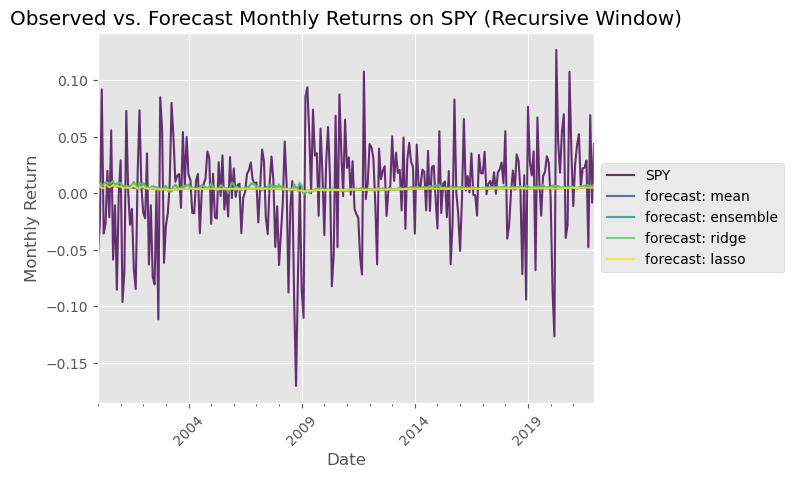

In [24]:
# Plotting forecasts vs. actual Returns
df_y = df_var[['Date', 'Excess Returns (SPY)']].copy()
sp_forecast = df_y.merge(df_mean_forecast[['Date', 'Excess Returns (SPY)']], how='inner', 
                         on='Date').merge(sp_forecast_ols[['Date', 'forecast: ensemble']], how='inner', 
                                          on='Date').merge(sp_forecast_pen, how='inner', on='Date')

sp_forecast.rename(columns={'Excess Returns (SPY)_x': 'SPY', 
                            'Excess Returns (SPY)_y': 'forecast: mean'}, inplace=True)

sp_forecast.plot(kind='line', x='Date', colormap='viridis', alpha=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.ylabel('Monthly Return')
plt.title('Observed vs. Forecast Monthly Returns on SPY (Recursive Window)')
plt.show()

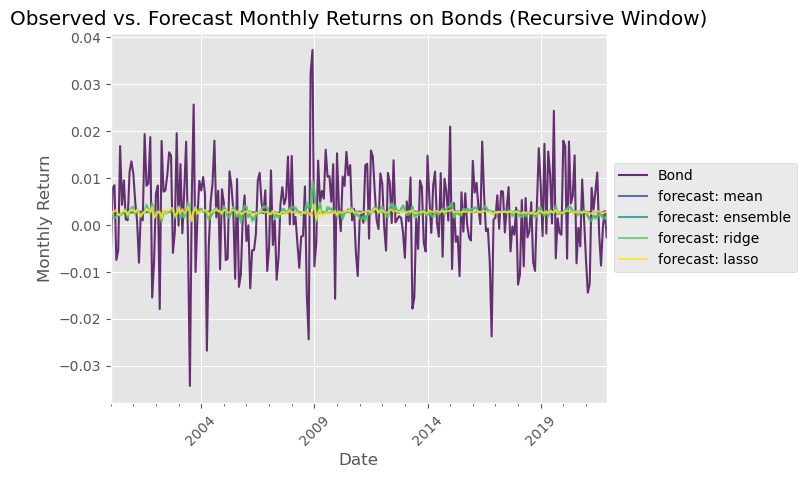

In [25]:
df_y = df_var[['Date', 'Excess Returns (Bond)']].copy()
bond_forecast = df_y.merge(df_mean_forecast[['Date', 'Excess Returns (Bond)']], how='inner', 
                           on='Date').merge(bond_forecast_ols[['Date', 'forecast: ensemble']], how='inner', 
                                            on='Date').merge(bond_forecast_pen, how='inner', on='Date')

bond_forecast.rename(columns={'Excess Returns (Bond)_x': 'Bond',
                               'Excess Returns (Bond)_y': 'forecast: mean'}, inplace=True)

bond_forecast.plot(kind='line', x='Date', colormap='viridis', alpha=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.ylabel('Monthly Return')
plt.title('Observed vs. Forecast Monthly Returns on Bonds (Recursive Window)')
plt.show()

#### Question 4

In [26]:
# Function
def recurs_covar_forecast(df, startDate_insample, endDate_insample,
                           startDate_outsample, endDate_outsample):
    # Divide into in-sample & out of sample periods
    df_insample, df_outsample = sample_split(df, startDate_insample, 
                                             endDate_insample, startDate_outsample, endDate_outsample)

    # Create DataFrame
    forecast_arr = np.empty(shape=(1,4))
    for i in range(len(df_insample), len(df)):
        forecast_arr = np.concatenate((forecast_arr, df.drop(
            columns='Date').iloc[:i].cov().values.reshape(1,4)), axis=0)
    
    forecast_arr = forecast_arr[1:,:]
    forecast_df = pd.DataFrame(forecast_arr)
    forecast_df.columns = ['var_x', 'cov_xy', 'cov_yx', 'var_y']
    forecast_df.insert(0, 'Date', df_outsample['Date'])
    
    return forecast_df

df_covar_forecast = recurs_covar_forecast(df_final, startDate_insample, endDate_insample,
                                           startDate_outsample, endDate_outsample)

#### Question 5

In [27]:
# Q5 - Prepare DataFrames
sp_forecast = df_mean_forecast[['Date', 'Excess Returns (SPY)']].merge(
    sp_forecast_ols, how='inner', on='Date').merge(sp_forecast_pen, how='inner', on='Date')
sp_forecast.rename(columns={'Excess Returns (SPY)': 'forecast: mean'}, inplace=True)

bond_forecast = df_mean_forecast[['Date', 'Excess Returns (Bond)']].merge(
    bond_forecast_ols, how='inner', on='Date').merge(bond_forecast_pen, how='inner', on='Date')
bond_forecast.rename(columns={'Excess Returns (Bond)': 'forecast: mean'}, inplace=True)

In [28]:
# Q5
def tangency_portfolio_weights(df_mean, df_covar):

    # Drop Date & Convert to numpy arrays
    arr_mu = df_mean.drop(columns='Date').to_numpy()
    arr_cov = df_covar.drop(columns='Date').to_numpy()

    opt_t_weights = pd.DataFrame(columns=['Date', 'w1', 'w2'])
    opt_t_weights['Date'] = df_covar['Date'].copy()

    # Reshape arrays and Calculate weights
    for i in range(0, len(df_covar)):
        mu = arr_mu[i].reshape(2,1)
        cov = arr_cov[i].reshape(2,2)

        num = np.linalg.inv(cov).dot(mu)
        denom = np.ones(2).T @ np.linalg.inv(cov).dot(mu)
        w_tp = np.divide(num, denom)
        w_tp = w_tp.reshape(2,)
        
        opt_t_weights.loc[i,['w1', 'w2']] = w_tp.T
    return opt_t_weights

opt_t_weights = tangency_portfolio_weights(df_mean_forecast, df_covar_forecast)

In [29]:
# Q5 - Annualised Summary Stats
# Q5 - Compute Annualised Summary Stats of Optimal Portfolio's Excess Returns
def annualised_portfolio_stats(weights, excess_returns):
    
    df_returns = pd.DataFrame()
    df_returns['Portfolio Excess Returns'] = (excess_returns.iloc[:,1]*weights.iloc[:,1] + 
                                              excess_returns.iloc[:,2]*weights.iloc[:,2])
    
    # Annualised Mean from Monthly Excess Returns
    port_mean = (1 + df_returns['Portfolio Excess Returns'].mean())**12 - 1

    # Annualised Standard Deviation from Monthly Excess Returns
    port_std_dev = df_returns['Portfolio Excess Returns'].std() * np.sqrt(12)

    # Annualised Sharpe Ratio from Monthly Excess Returns
    port_sharpe_ratio = port_mean / port_std_dev

    return port_mean, port_std_dev, port_sharpe_ratio

In [30]:
excess_returns = df_var[['Date', 'Excess Returns (SPY)', 'Excess Returns (Bond)']]

stats_lst = []
for column in sp_forecast.columns[1:]:

    df_mean_forecast = sp_forecast[['Date', column]].merge(bond_forecast[['Date', column]], 
                                                           on='Date', how='inner', suffixes=('_SPY', '_Bond'))
    weights = tangency_portfolio_weights(df_mean_forecast, df_covar_forecast)
    stats_lst.append(annualised_portfolio_stats(weights, excess_returns))

df_tangency = pd.DataFrame(stats_lst, index=sp_forecast.columns[1:],
                            columns=['Mean Excess Return', 'Std. Dev of Excess Return', 'Sharpe Ratio'])

In [31]:
df_tangency

,Mean Excess Return,Std. Dev of Excess Return,Sharpe Ratio
forecast: mean,0.036831,0.061503,0.598850
forecast: tbl,0.032100,0.070074,0.458080
forecast: infl,0.004835,0.131128,0.036871
forecast: ltr,0.073996,0.091392,0.809657
forecast: E12,0.079093,0.139313,0.567738
forecast: ntis,0.028126,0.064986,0.432802
forecast: ensemble,0.039217,0.064678,0.606337
forecast: ridge,0.039604,0.065886,0.601101
forecast: lasso,0.038706,0.062343,0.620864


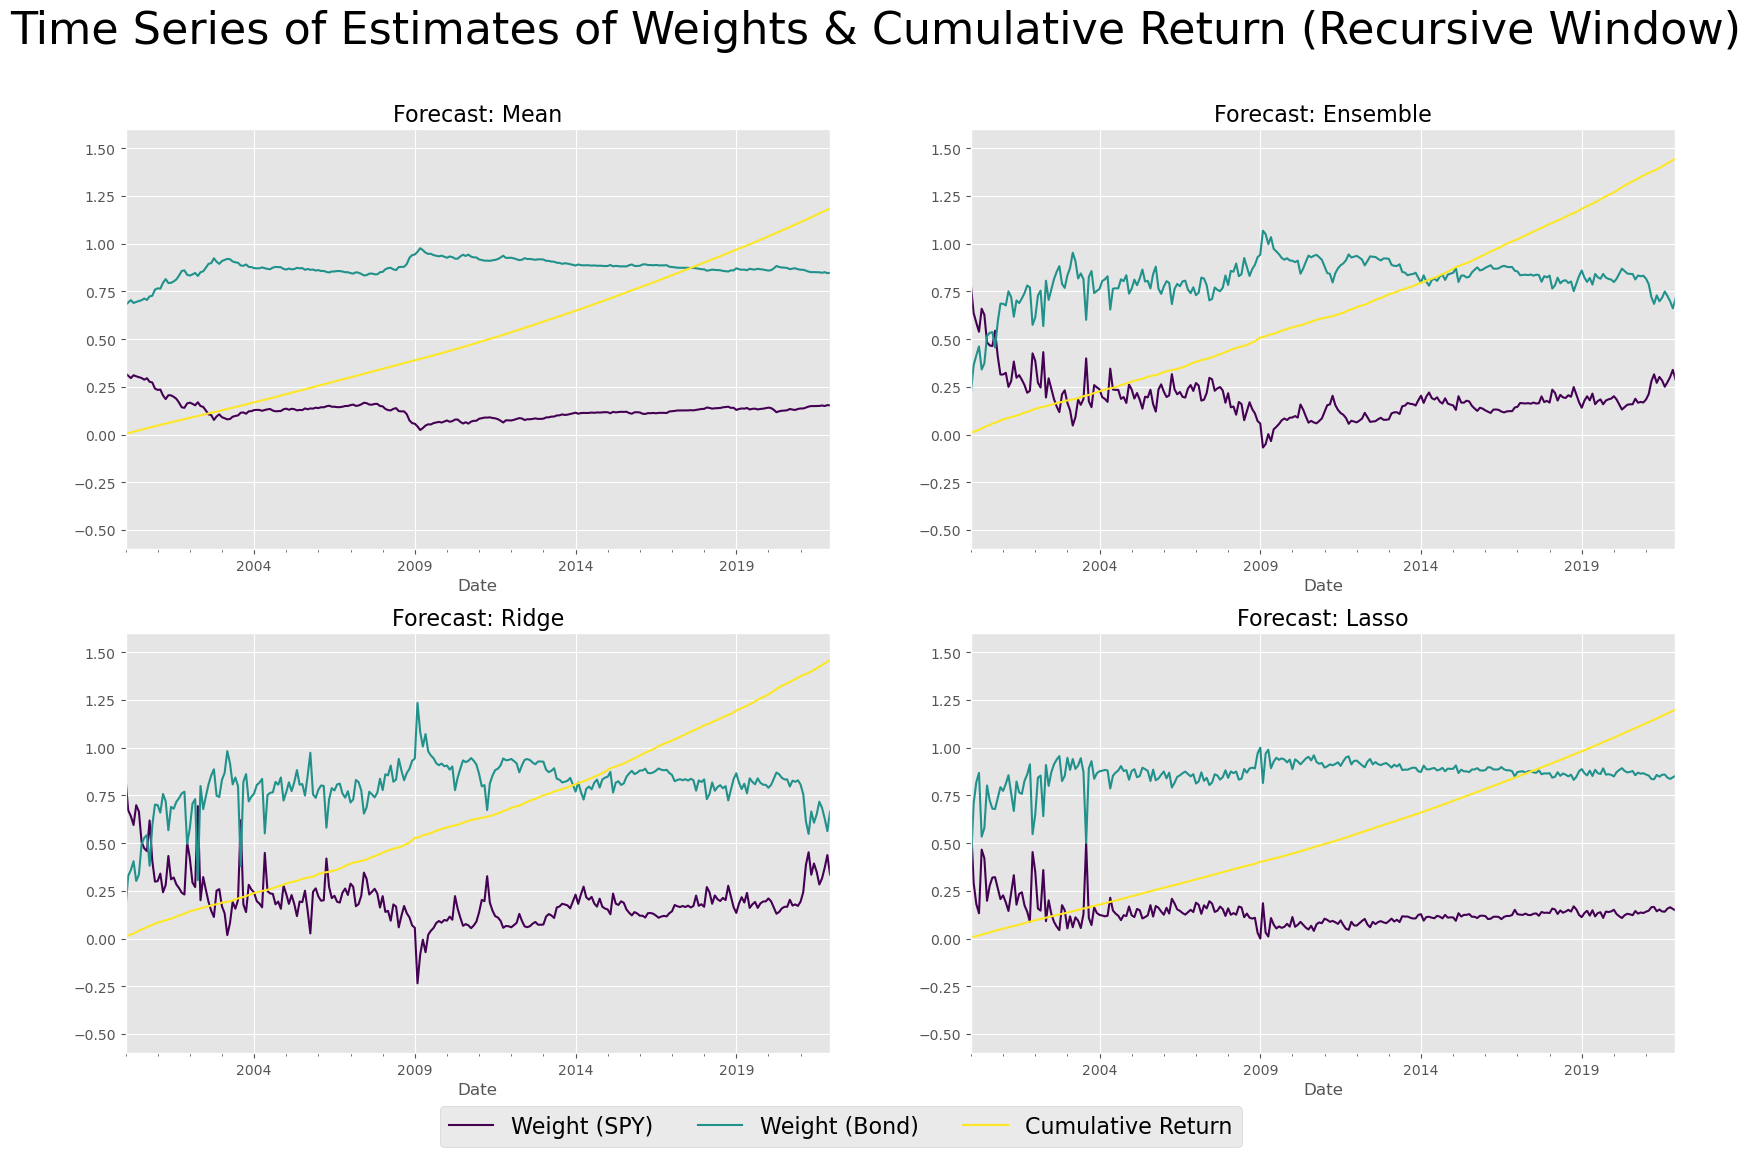

In [32]:
# sp_forecast
def cumulative_excess_return(weights, excess_returns):
    
    df_returns = pd.DataFrame()
    df_returns['Date'] = weights.iloc[:,0]
    df_returns['Weight (SPY)'] = weights.iloc[:,1]
    df_returns['Weight (Bond)'] = weights.iloc[:,2]
    df_returns['Cumulative Excess Returns'] = (excess_returns.iloc[:,1]*weights.iloc[:,1] + 
                                               excess_returns.iloc[:,2]*weights.iloc[:,2]+1).cumprod()-1

    return df_returns

fig, axs = plt.subplots(2, 2, figsize=(20,12))
fig.suptitle('Time Series of Estimates of Weights & Cumulative Return (Recursive Window)', fontsize=32)

forecasts = ['forecast: mean', 'forecast: ensemble', 'forecast: ridge', 'forecast: lasso']
for forecast, ax in zip(forecasts, axs.ravel()):
    df_mean_forecast = sp_forecast[['Date', forecast]].merge(bond_forecast[['Date', forecast]],
                                                on='Date', how='inner', suffixes=('_SPY', '_Bond'))
    weights = tangency_portfolio_weights(df_mean_forecast, df_covar_forecast)

    cumulative_excess_return(weights, df_mean_forecast).plot(kind='line', x='Date',
                                                              cmap='viridis', ax=ax, legend=False)
    ax.set_ylim((-0.6,1.6))
    ax.set_title(forecast.title(), fontsize=16)
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.legend(['Weight (SPY)','Weight (Bond)','Cumulative Return'], bbox_to_anchor=(0.4, -0.1),
                                                                         ncol=3, fontsize=16)
plt.show()

#### Question 6

In [33]:
# Function
def rolling_mean_forecast(df, startDate_insample, endDate_insample,
                                startDate_outsample, endDate_outsample):

    # Divide into in-sample & out of sample periods
    df_insample, df_outsample = sample_split(df, startDate_insample,
                endDate_insample, startDate_outsample, endDate_outsample)
    window = len(df_insample)
    
    # Create DataFrame
    forecast_df = pd.DataFrame(columns=df.columns)
    forecast_df[df.columns[1:]] = df[df.columns[1:]].rolling(window=window).mean(
        numeric_only=True)[window:].reset_index(drop=True)
    forecast_df['Date'] = df_outsample['Date'].reset_index(drop=True)
    
    return forecast_df

df_mean_forecast_roll = rolling_mean_forecast(df_final, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample)

In [34]:
def RollingLS_Ordinary(df_x, df_y, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample):

    # call sample_split() to split dfs into in & out of sample periods
    df_x_insample, df_x_outsample = sample_split(df_x, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample)
    df_y_insample, df_y_outsample = sample_split(df_y, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample)

    df_y_insample.drop(columns='Date', inplace=True)
    out_date = df_y_outsample.pop('Date')
   
    df_forecast_ols = pd.DataFrame()
    
    for variable in df_x_insample.drop(columns=['Date']).columns:
        
        forecast = pd.DataFrame()
        col_name = 'forecast: ' + variable
        
        # set up data for OLS 
        df_x_insample_var = sm.add_constant(df_x_insample[variable])
        df_x_outsample_var = sm.add_constant(df_x_outsample[variable])
        df_y_insample_copy = df_y_insample.copy()
        
        for i, exog_i in enumerate(df_y_outsample.values):
            
            # extract endogenous variables of ith observation
            endog_i = df_x_outsample_var.loc[df_x_outsample_var.index==i]

            # Fit our OLS model on in-sample period
            model = sm.OLS(df_y_insample_copy, df_x_insample_var)
            res = model.fit()

            # append prediction to forecast
            forecast = pd.concat([forecast, res.predict(endog_i)], axis=0, ignore_index=True)

            # Include previous observation in next insample
            df_x_insample_var = pd.concat([df_x_insample_var, endog_i], axis=0, ignore_index=True)
            df_y_insample_copy = pd.concat([df_y_insample_copy, pd.DataFrame(exog_i, columns=df_y_insample_copy.columns)], axis=0, ignore_index=True)

        df_forecast_ols[col_name] = forecast

    df_forecast_ols.insert(0, 'Date', out_date)

    return df_forecast_ols

In [35]:
df_y = df_var[['Date', 'Excess Returns (SPY)']]

sp_forecast_ols_roll = RollingLS_Ordinary(df_var_sp, df_y, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample)
sp_forecast_ols_roll['forecast: ensemble'] = sp_forecast_ols_roll.mean(axis=1, numeric_only=True)

In [36]:
df_y = df_var[['Date', 'Excess Returns (Bond)']]

bond_forecast_ols_roll = RollingLS_Ordinary(df_var_bond, df_y, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample)
bond_forecast_ols_roll['forecast: ensemble'] = bond_forecast_ols_roll.mean(axis=1, numeric_only=True)

In [37]:
def RollingLS_Penalized(df_x, df_y, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample):

    # call sample_split() to split dfs into in & out of sample periods
    df_x_insample, df_x_outsample = sample_split(df_x, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample)
    df_y_insample, df_y_outsample = sample_split(df_y, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample)

    df_x_insample.drop(columns='Date', inplace=True)
    df_y_insample.drop(columns='Date', inplace=True)
    df_x_outsample.drop(columns='Date', inplace=True)
    out_date = df_y_outsample.pop('Date')
   
    df_forecast_pen = pd.DataFrame()
    
    for L1_wt in [0,1]: # 0 corresponds to ridge regression, 1 to lasso
            
        forecast = pd.DataFrame()
        if L1_wt == 0:
            col_name = 'forecast: ridge'
            alpha = 2.75
        else:
            col_name = 'forecast: lasso'
            alpha = 0.12
        
        for i, exog_i in enumerate(df_y_outsample.values):
            
            # Standardize exogenous variables
            exog_i = pd.DataFrame(exog_i, columns=df_y_insample.columns)
            df_y_insample_standard, scaler_y = Standardizer(df_y.iloc[i:len(df_y_insample)+i,1:])
            exog_i = scaler_y.transform(exog_i)

            # extract variables of ith observation
            endog_i = df_x_outsample.iloc[i,:]
            
            # Standardize endogenous variables
            df_x_insample_standard, scaler_x = Standardizer(df_x.iloc[i:len(df_y_insample)+i,1:])
            endog_i = scaler_x.transform(pd.DataFrame(endog_i.values.reshape(1, -1), columns=df_x_insample.columns))
            
            # Fit our OLS model on in-sample period
            model = sm.OLS(df_y_insample_standard, df_x_insample_standard)
            res = model.fit_regularized(method='elastic_net', L1_wt=L1_wt, alpha=alpha)

            # Transform forecast back to raw returns & append to forecast df
            raw_forecast = scaler_y.mean_ + scaler_y.scale_ * pd.Series(res.predict(endog_i))
            forecast = pd.concat([forecast, raw_forecast], axis=0, ignore_index=True)

        df_forecast_pen[col_name] = forecast
    df_forecast_pen.insert(0, 'Date', out_date)

    return df_forecast_pen

In [38]:
df_y = df_var[['Date', 'Excess Returns (SPY)']]

sp_forecast_pen_roll = RollingLS_Penalized(df_var_sp, df_y, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample)

In [39]:
df_y = df_var[['Date', 'Excess Returns (Bond)']]

bond_forecast_pen_roll = RollingLS_Penalized(df_var_bond, df_y, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample)

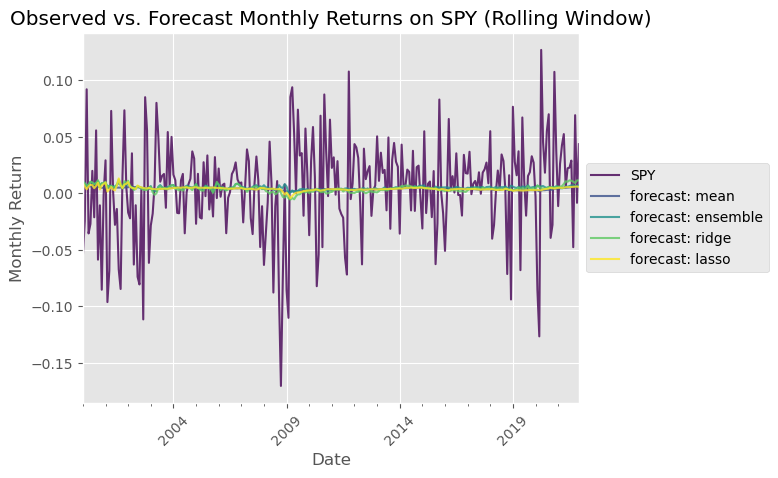

In [40]:
df_y = df_var[['Date', 'Excess Returns (SPY)']].copy()
sp_forecast_roll = df_y.merge(df_mean_forecast_roll[['Date', 'Excess Returns (SPY)']], how='inner', on='Date').merge(
    sp_forecast_ols_roll[['Date', 'forecast: ensemble']], how='inner', on='Date').merge(sp_forecast_pen_roll, how='inner', on='Date')

sp_forecast_roll.rename(columns={'Excess Returns (SPY)_x': 'SPY', 'Excess Returns (SPY)_y': 'forecast: mean'}, inplace=True)

sp_forecast_roll.plot(kind='line', x='Date', colormap='viridis', alpha=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.ylabel('Monthly Return')
plt.title('Observed vs. Forecast Monthly Returns on SPY (Rolling Window)')
plt.show()

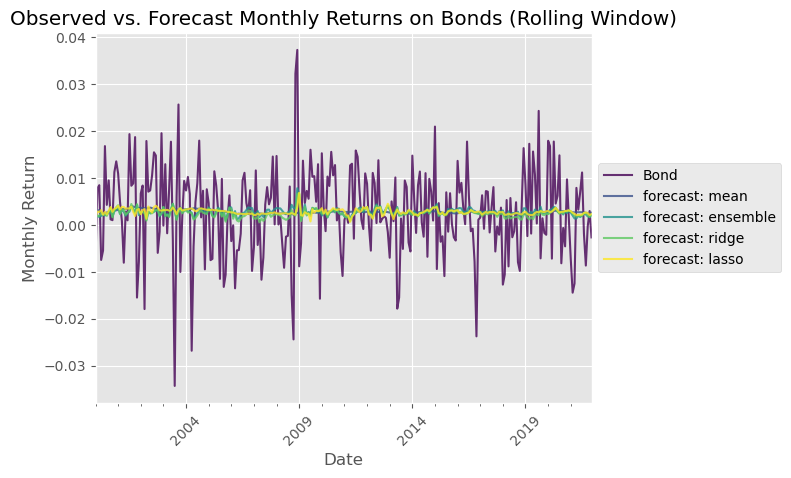

In [41]:
df_y = df_var[['Date', 'Excess Returns (Bond)']].copy()
bond_forecast_roll = df_y.merge(df_mean_forecast_roll[['Date', 'Excess Returns (Bond)']], how='inner', on='Date').merge(
    bond_forecast_ols_roll[['Date', 'forecast: ensemble']], how='inner', on='Date').merge(bond_forecast_pen_roll, how='inner', on='Date')

bond_forecast_roll.rename(columns={'Excess Returns (Bond)_x': 'Bond', 'Excess Returns (Bond)_y': 'forecast: mean'}, inplace=True)

bond_forecast_roll.plot(kind='line', x='Date', colormap='viridis', alpha=0.8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45)
plt.ylabel('Monthly Return')
plt.title('Observed vs. Forecast Monthly Returns on Bonds (Rolling Window)')
plt.show()

In [42]:
# Q3 - Prepare DataFrame for DM-Test (SPY)
df_y = df_var[['Date', 'Excess Returns (SPY)']].copy()
sp_forecast_roll = df_y.merge(df_mean_forecast_roll[['Date', 'Excess Returns (SPY)']], how='inner', on='Date').merge(
    sp_forecast_ols_roll, how='inner', on='Date').merge(sp_forecast_pen_roll, how='inner', on='Date')

sp_forecast_roll.rename(columns={'Excess Returns (SPY)_x': 'SPY', 'Excess Returns (SPY)_y': 'forecast: mean'}, inplace=True)

# Prepare DataFrames for DM-Test Storage
dm_test_stats_spy_roll = pd.DataFrame(columns=['Model (SPY)',  'MSFE Ratio', 'Test Statistic', 'p-value'])

# Run DM-Test for each model
for column in sp_forecast_roll.columns[3:]:

    test_stat, p_value, msfe_ratio = DM_test(sp_forecast_roll, 'SPY', 'forecast: mean', column)
    dm_test_stats_spy_roll = pd.concat([dm_test_stats_spy_roll, pd.Series([column, msfe_ratio, test_stat, p_value], index=dm_test_stats_spy.columns).to_frame().T], ignore_index=True)

In [43]:
dm_test_stats_spy_roll

,Model (SPY),MSFE Ratio,Test Statistic,p-value
0,forecast: tbl,0.98606,-0.000348,0.500139
1,forecast: infl,0.969974,-0.000751,0.500299
2,forecast: ltr,0.994446,-0.000398,0.500159
3,forecast: E12,0.979692,-0.000558,0.500223
4,forecast: ntis,0.983453,-0.000435,0.500174
5,forecast: ensemble,0.986856,-0.000385,0.500154
6,forecast: ridge,0.9853,-0.000491,0.500196
7,forecast: lasso,0.987119,-0.000532,0.500212


In [44]:
# Q3 - Prepare DataFrame for DM-Test (Bond)
df_y = df_var[['Date', 'Excess Returns (Bond)']].copy()
bond_forecast_roll = df_y.merge(df_mean_forecast_roll[['Date', 'Excess Returns (Bond)']], how='inner', on='Date').merge(
    bond_forecast_ols_roll, how='inner', on='Date').merge(bond_forecast_pen_roll, how='inner', on='Date')

bond_forecast_roll.rename(columns={'Excess Returns (Bond)_x': 'Bond', 'Excess Returns (Bond)_y': 'forecast: mean'}, inplace=True)

# Prepare DataFrames for DM-Test Storage
dm_test_stats_bond_roll = pd.DataFrame(columns=['Model (Bond)',  'MSFE Ratio', 'Test Statistic', 'p-value'])

# Run DM-Test for each model
for column in bond_forecast_roll.columns[3:]:
        
    test_stat, p_value, msfe_ratio = DM_test(bond_forecast_roll, 'Bond', 'forecast: mean', column)
    dm_test_stats_bond_roll = pd.concat([dm_test_stats_bond_roll, pd.Series([column, msfe_ratio, test_stat, p_value], index=dm_test_stats_bond.columns).to_frame().T], ignore_index=True)

In [45]:
dm_test_stats_bond_roll

,Model (Bond),MSFE Ratio,Test Statistic,p-value
0,forecast: tbl,0.97841,-0.000055,0.500022
1,forecast: infl,0.994839,-0.000011,0.500004
2,forecast: ltr,0.969946,-0.000089,0.500036
3,forecast: E12,0.975907,-0.000034,0.500014
4,forecast: ntis,0.933784,-0.000099,0.500039
5,forecast: ensemble,0.994654,-0.000013,0.500005
6,forecast: ridge,0.990899,-0.000019,0.500008
7,forecast: lasso,0.981653,-0.00003,0.500012


In [46]:
# Function
def rolling_covar_forecast(df, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample):
    # Divide into in-sample & out of sample periods
    df_insample, df_outsample = sample_split(df, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample)

    forecast_df = df.drop(columns='Date').rolling(window=len(df_insample), closed='left').cov().unstack().dropna()

    forecast_df.columns = ['cov_xy', 'var_x', 'var_y', 'cov_yx']
    # reorder columns
    cols = ['var_x', 'cov_xy', 'cov_yx', 'var_y']
    forecast_df = forecast_df[cols].reset_index(drop=True)
    forecast_df.insert(0, 'Date', df_outsample['Date'])
    
    return forecast_df

df_covar_forecast_roll = rolling_covar_forecast(df_final, startDate_insample, endDate_insample, startDate_outsample, endDate_outsample)

In [47]:
# Q3 - Prepare DataFrame for DM-Test (Bond)
df_y = df_var[['Date', 'Excess Returns (Bond)']].copy()
bond_forecast_roll = df_y.merge(df_mean_forecast_roll[['Date', 'Excess Returns (Bond)']], how='inner', on='Date').merge(
    bond_forecast_ols_roll, how='inner', on='Date').merge(bond_forecast_pen_roll, how='inner', on='Date')

bond_forecast_roll.rename(columns={'Excess Returns (Bond)_x': 'Bond', 'Excess Returns (Bond)_y': 'forecast: mean'}, inplace=True)

# Prepare DataFrames for DM-Test Storage
dm_test_stats_bond_roll = pd.DataFrame(columns=['Model (Bond)',  'MSFE Ratio', 'Test Statistic', 'p-value'])

# Run DM-Test for each model
for column in bond_forecast_roll.columns[3:]:
        
    test_stat, p_value, msfe_ratio = DM_test(bond_forecast_roll, 'Bond', 'forecast: mean', column)
    dm_test_stats_bond_roll = pd.concat([dm_test_stats_bond_roll, pd.Series([column, msfe_ratio, test_stat, p_value], index=dm_test_stats_bond.columns).to_frame().T], ignore_index=True)

In [48]:
# Q5 - Prepare DataFrames
sp_forecast_roll = df_mean_forecast_roll[['Date', 'Excess Returns (SPY)']].merge(
    sp_forecast_ols_roll, how='inner', on='Date').merge(sp_forecast_pen_roll, how='inner', on='Date')
sp_forecast_roll.rename(columns={'Excess Returns (SPY)': 'forecast: mean'}, inplace=True)

bond_forecast_roll = df_mean_forecast_roll[['Date', 'Excess Returns (Bond)']].merge(
    bond_forecast_ols_roll, how='inner', on='Date').merge(bond_forecast_pen_roll, how='inner', on='Date')
bond_forecast_roll.rename(columns={'Excess Returns (Bond)': 'forecast: mean'}, inplace=True)

In [49]:
opt_t_weights_roll = tangency_portfolio_weights(df_mean_forecast_roll, df_covar_forecast_roll)

In [50]:
# Q6 - Compute Annualised Summary Stats of Optimal Portfolio's Excess Returns
def annualised_portfolio_stats(weights, excess_returns):
    
    df_returns = pd.DataFrame()
    df_returns['Portfolio Excess Returns'] = (excess_returns.iloc[:,1]*weights.iloc[:,1] + excess_returns.iloc[:,2]*weights.iloc[:,2])
    
    # Annualised Mean from Monthly Excess Returns
    port_mean = (1 + df_returns['Portfolio Excess Returns'].mean())**12 - 1

    # Annualised Standard Deviation from Monthly Excess Returns
    port_std_dev = df_returns['Portfolio Excess Returns'].std() * np.sqrt(12)

    # Annualised Sharpe Ratio from Monthly Excess Returns
    port_sharpe_ratio = port_mean / port_std_dev

    return port_mean, port_std_dev, port_sharpe_ratio

In [51]:
excess_returns = df_var[['Date', 'Excess Returns (SPY)', 'Excess Returns (Bond)']]

stats_lst = []
for column in sp_forecast_roll.columns[1:]:

    df_mean_forecast_roll = sp_forecast_roll[['Date', column]].merge(bond_forecast_roll[['Date', column]], on='Date', how='inner', suffixes=('_SPY', '_Bond'))
    weights_roll = tangency_portfolio_weights(df_mean_forecast_roll, df_covar_forecast_roll)
    stats_lst.append(annualised_portfolio_stats(weights_roll, excess_returns))

df_tangency_roll = pd.DataFrame(stats_lst, index=sp_forecast_roll.columns[1:],
                            columns=['Mean Excess Return', 'Std. Dev of Excess Return', 'Sharpe Ratio'])

In [52]:
df_tangency_roll

,Mean Excess Return,Std. Dev of Excess Return,Sharpe Ratio
forecast: mean,0.034877,0.060407,0.577374
forecast: tbl,0.031585,0.062426,0.505954
forecast: infl,0.025931,0.068057,0.381026
forecast: ltr,0.063871,0.081212,0.786472
forecast: E12,0.082285,0.145020,0.567404
forecast: ntis,0.030322,0.064251,0.471932
forecast: ensemble,0.038180,0.060467,0.631412
forecast: ridge,0.040060,0.060449,0.662704
forecast: lasso,0.036979,0.060708,0.609116


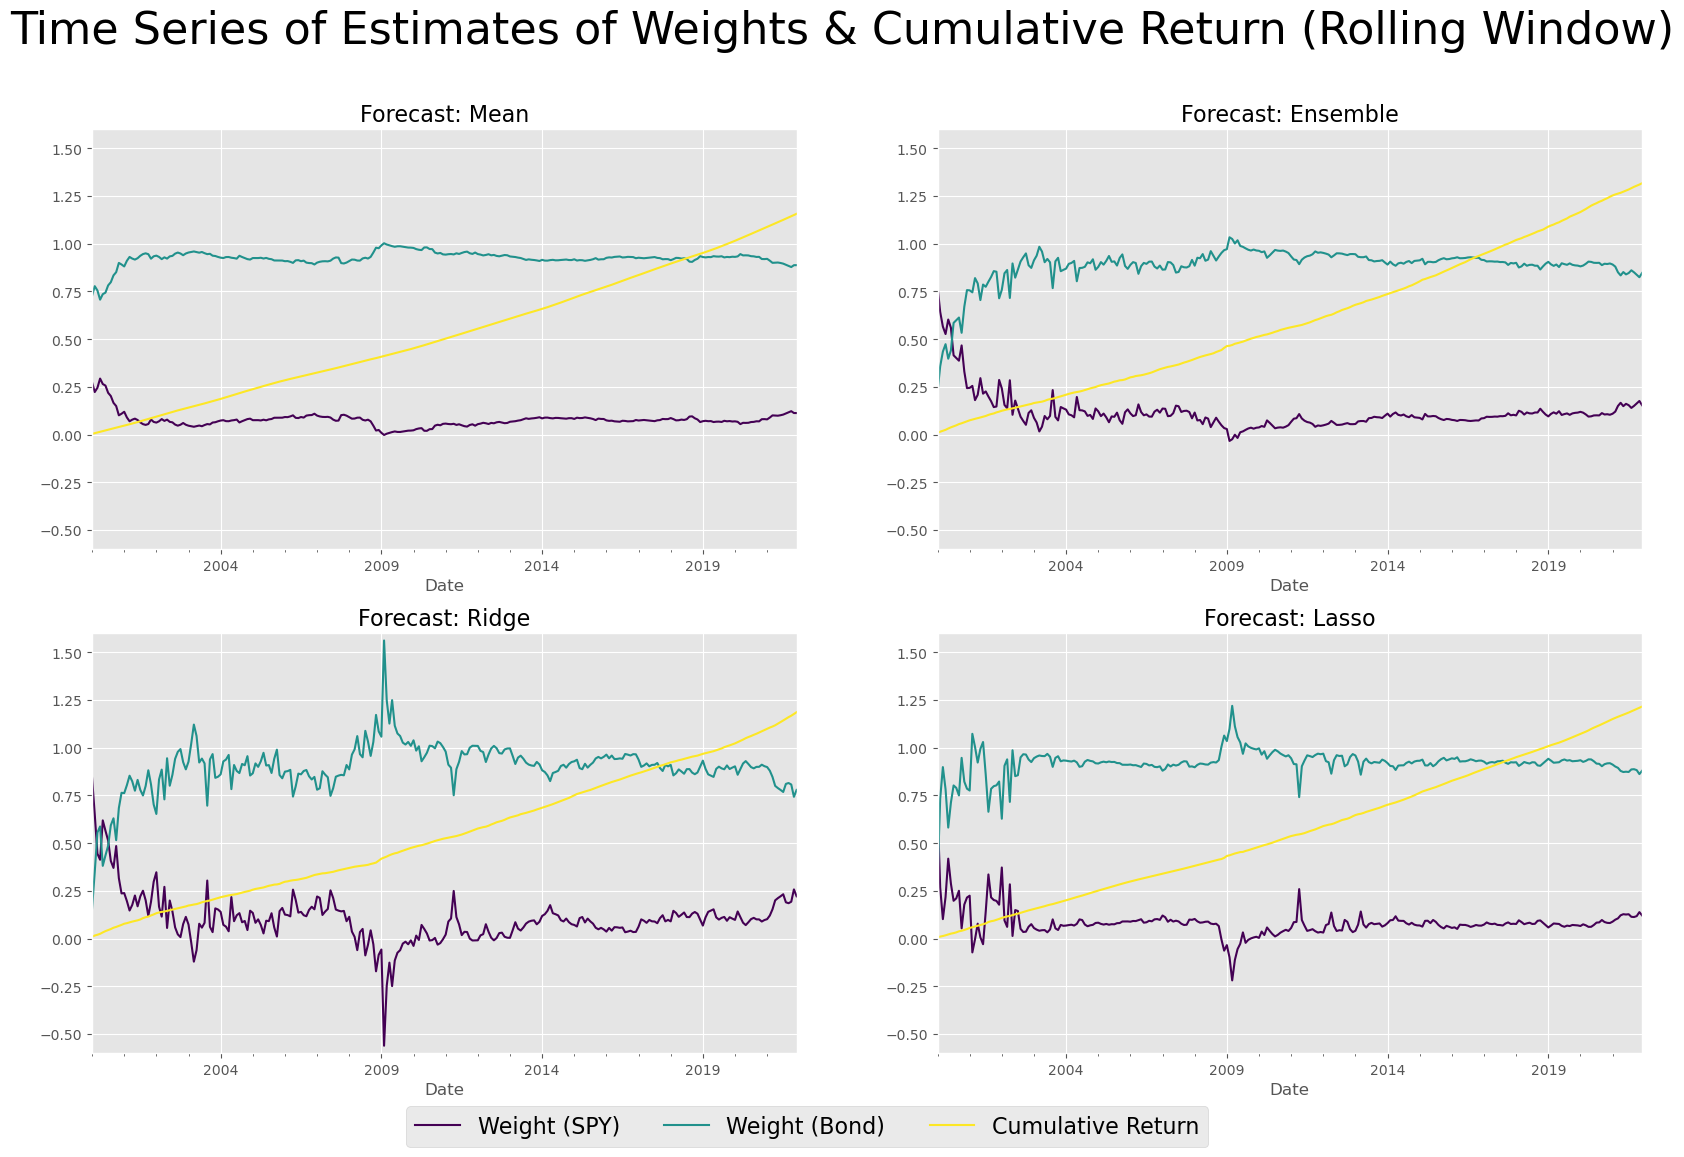

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(20,12))
fig.suptitle('Time Series of Estimates of Weights & Cumulative Return (Rolling Window)', fontsize=32)

forecasts = ['forecast: mean', 'forecast: ensemble', 'forecast: ridge', 'forecast: lasso']
for forecast, ax in zip(forecasts, axs.ravel()):
    df_mean_forecast_roll = sp_forecast_roll[['Date', forecast]].merge(bond_forecast_roll[['Date', forecast]], on='Date', how='inner', suffixes=('_SPY', '_Bond'))
    weights_roll = tangency_portfolio_weights(df_mean_forecast_roll, df_covar_forecast_roll)

    cumulative_excess_return(weights_roll, df_mean_forecast_roll).plot(kind='line', x='Date', cmap='viridis', ax=ax, legend=False)
    ax.set_ylim((-0.6,1.6))
    ax.set_title(forecast.title(), fontsize=16)

plt.legend(['Weight (SPY)','Weight (Bond)','Cumulative Return'], bbox_to_anchor=(0.4, -0.1), ncol=3, fontsize=16)
plt.show()